In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch
import numpy as np
from PIL import Image
import os
%load_ext autoreload
%autoreload 2



from tqdm import tqdm


In [2]:
data_dir = './xray_dataset/'
# convert all input images to square tensors
# this step is probably ruining the data
transform = transforms.Compose([
    transforms.RandomResizedCrop((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.ColorJitter(brightness=0.3),
    transforms.RandomRotation(15),
    # normalize the data
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load training data
train_data = ImageFolder(root=data_dir + 'train', transform=transform)

# Load validation data
val_data = ImageFolder(root=data_dir + 'val', transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

# Load test data
test_data = ImageFolder(root=data_dir + 'test', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


100%|██████████| 624/624 [00:16<00:00, 37.44it/s]


Recall: 0.8692307692307693
Accuracy: 0.6426282051282052
F1: 0.7524972253052165


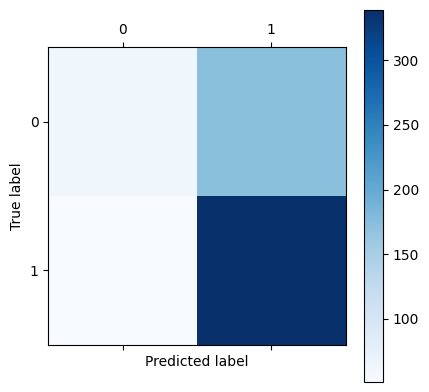

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from CNN import *
from captum.attr import IntegratedGradients
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score

# Define paths and constants
MODEL_PATH = './xray_net_20epoch.pth'
DEVICE = 'cuda'
NUM_CLASSES = 2

# Load the model and test data
model = CNN().to(DEVICE)
model.load_state_dict(torch.load(
    MODEL_PATH, map_location=torch.device(DEVICE)))
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

# Generate predictions and labels for the test data
all_predictions = []
all_labels = []
for images, labels in tqdm(test_loader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Generate a prediction for the current sample
    with torch.no_grad():
        output = model(images)
    predictions = torch.argmax(output, dim=1)

    all_predictions.append(predictions.item())
    all_labels.append(labels.item())

# Calculate the recall and accuracy scores
recall = recall_score(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

f1 = f1_score(all_labels, all_predictions)

# Print the recall and accuracy scores
print('Recall:', recall)
print('Accuracy:', accuracy)
print('F1:', f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Predictions: tensor(1, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Healthy sample: 1


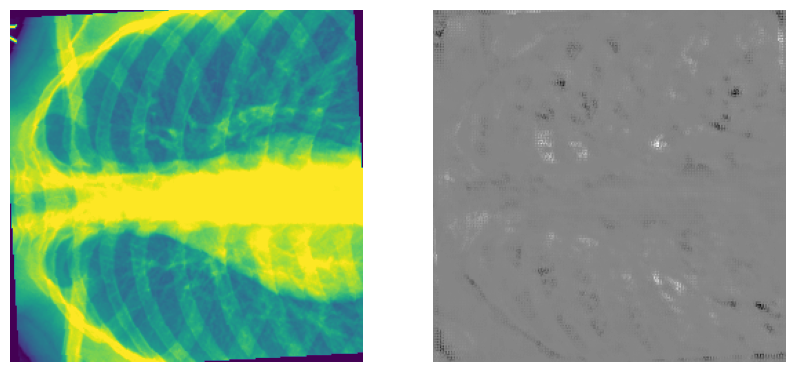

Predictions: tensor(0, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Healthy sample: 2


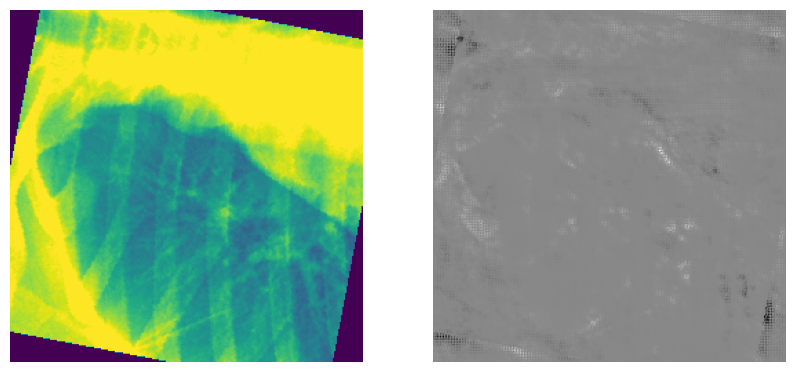

Predictions: tensor(1, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Healthy sample: 3


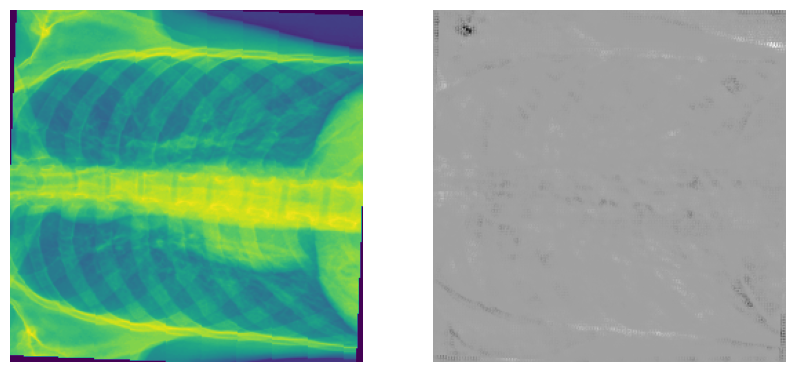

Predictions: tensor(1, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Healthy sample: 4


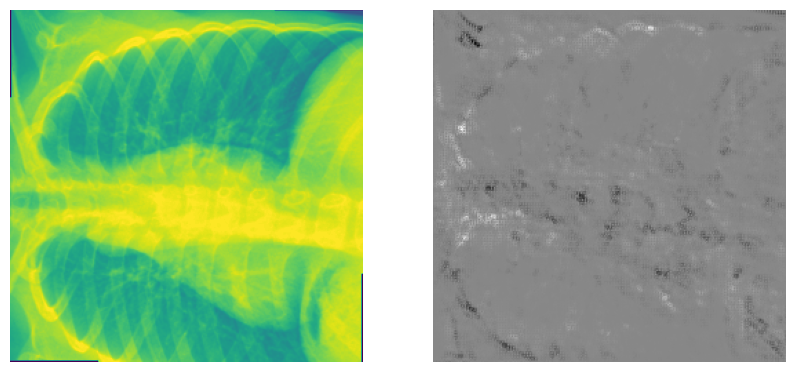

Predictions: tensor(1, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Healthy sample: 5


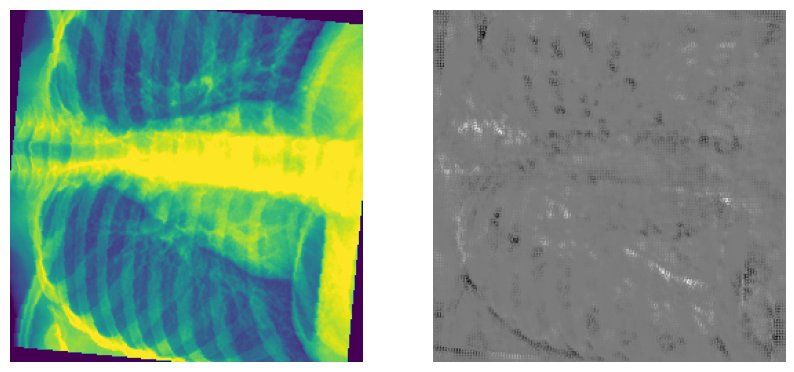

Predictions: tensor(0, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Pneumonia sample: 1


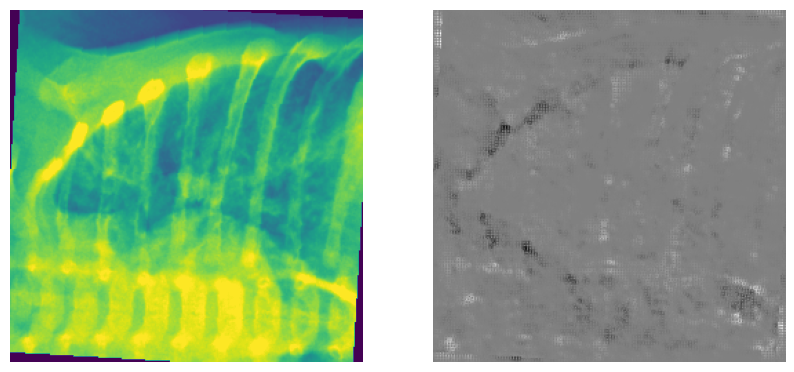

Predictions: tensor(1, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Pneumonia sample: 2


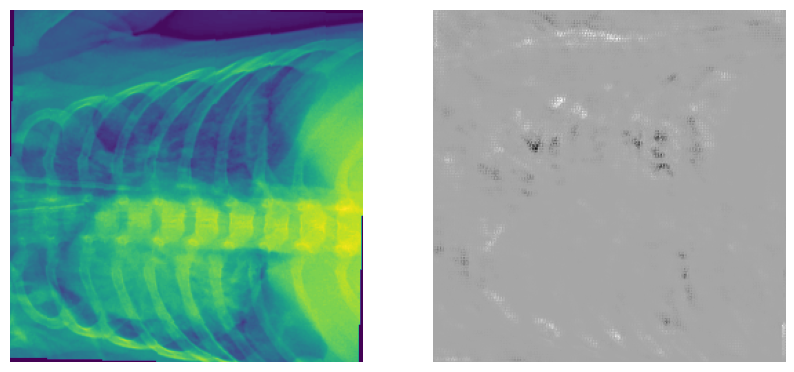

Predictions: tensor(1, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Pneumonia sample: 3


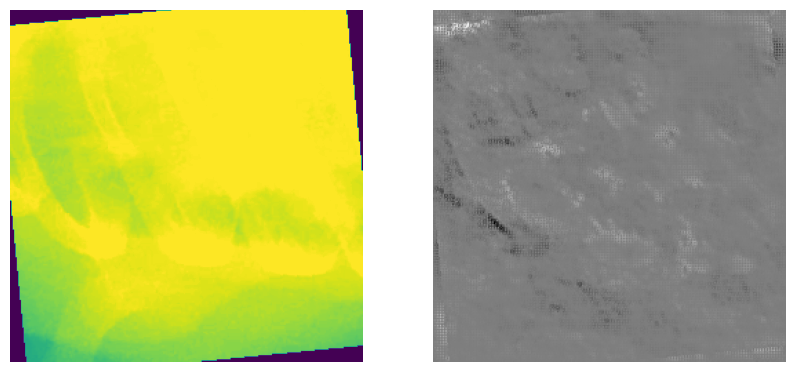

Predictions: tensor(1, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Pneumonia sample: 4


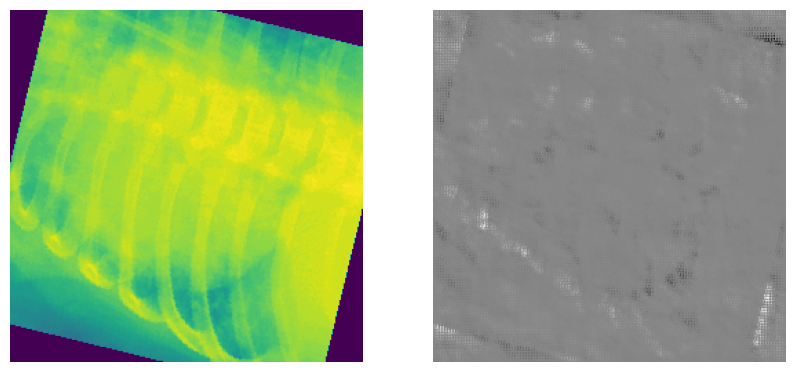

Predictions: tensor(1, device='cuda:0')
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
Pneumonia sample: 5


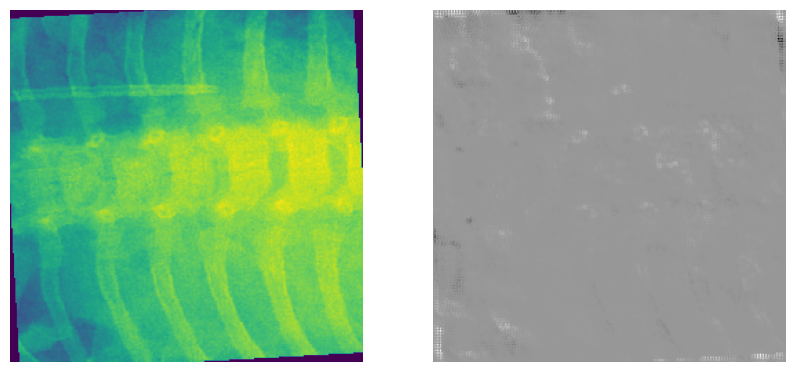

In [6]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from CNN import *


from captum.attr import IntegratedGradients
from PIL import Image

# Move the model and test data to the GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cuda'
model = CNN().to(device)
model.load_state_dict(torch.load(
    MODEL_PATH, map_location=torch.device(device)))
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

# Define the Integrated Gradients explainer
ig = IntegratedGradients(model.to(device))

# Define a helper function to display the attribution map on the original image


def visualize_attribution(original_image, attribution_map):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(original_image)
    ax1.axis('off')
    ax2.imshow(attribution_map, cmap='gray')
    ax2.axis('off')
    plt.show()


# Generate attribution maps for 5 healthy and 5 pneumonia test samples
healthy_count = 0
pneumonia_count = 0
for images, labels in test_loader:
    # Skip samples until we have 5 of each class
    if healthy_count == 5 and pneumonia_count == 5:
        break

    if labels == 0 and healthy_count == 5:
        # print('Skipping healthy sample')
        continue

    if labels == 1 and pneumonia_count == 5:
        # print('Skipping unhealthy sample')
        continue

    # Move images and labels to the GPU
    images = images.to(device)
    labels = labels.to(device)

    # print(images.shape, labels.shape)
    print("Predictions:", torch.argmax(model(images)))

    # Generate an attribution map for the current sample
    images.requires_grad = True
    attribution = ig.attribute(images, target=labels)
    print(attribution.shape, images.shape)

    attribution_map = np.transpose(
        attribution.squeeze().cpu().detach().numpy())
    # break

    attribution *= 1000
    # print(attribution_map)

    # print(attribution_map)
    # normalize attribution map
    # attribution_map = (attribution_map - np.min(attribution_map)) / \
    #     (np.max(attribution_map) - np.min(attribution_map)) * 255

    # print(attribution_map)

    # break

    # Display the attribution map on the original image
    if labels == 0 and healthy_count < 5:
        print('Healthy sample:', healthy_count+1)
        visualize_attribution(np.transpose(
            images.squeeze().cpu().detach().numpy()), attribution_map)
        healthy_count += 1
    elif labels == 1 and pneumonia_count < 5:
        print('Pneumonia sample:', pneumonia_count+1)
        visualize_attribution(np.transpose(
            images.squeeze().cpu().detach().numpy()), attribution_map)
        pneumonia_count += 1
